In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

#%matplotlib notebook

In [2]:
data = pd.read_json("parsed/my_replays.json")
#data.set_index(['id','f'],inplace=True)
data.head()

,f,ix,t,x,y,z,dx,dy,dz,scorer,pt,month,id
0,0,0,12.733936,0.00,0.00,92.87,0.00,0.00,0.00,1.0,0,2,02BC803B4481747BDB6B6FA3452F2796
1,127,0,18.879103,22.88,-38.32,94.99,1512.35,-2715.01,220.28,1.0,0,2,02BC803B4481747BDB6B6FA3452F2796
2,128,0,18.927488,98.43,-173.95,105.04,1510.01,-2710.87,187.44,1.0,0,2,02BC803B4481747BDB6B6FA3452F2796
3,129,0,18.975874,148.73,-264.25,110.84,1508.45,-2708.11,165.57,1.0,0,2,02BC803B4481747BDB6B6FA3452F2796
4,130,0,19.024260,249.17,-444.58,120.24,1505.33,-2702.59,121.91,1.0,0,2,02BC803B4481747BDB6B6FA3452F2796


In [3]:
data.describe()

,f,ix,t,x,y,z,dx,dy,dz,scorer,pt,month
count,334678.000000,334678.000000,334678.000000,334678.000000,334678.000000,334678.000000,334678.000000,334678.000000,334678.000000,334678.000000,334678.000000,334678.000000
mean,5541.596848,93.861679,244.040719,89.272086,-96.934779,418.518451,0.344782,-15.852722,4.396626,0.554781,4.125506,5.037316
std,3729.014576,65.993175,145.720900,2416.870786,2999.537926,420.582911,905.348108,1052.947806,480.920511,0.476737,3.263182,2.593399
min,0.000000,0.000000,0.400000,-5146.340000,-5994.700000,0.090000,-5060.700000,-4698.220000,-2357.310000,0.000000,0.000000,2.000000
25%,2614.000000,47.000000,123.687223,-1966.907500,-2721.067500,110.870000,-491.647500,-607.250000,-219.170000,0.000000,2.000000,3.000000
50%,5096.000000,92.000000,232.685365,7.360000,-10.120000,267.270000,0.000000,0.000000,0.000000,1.000000,4.000000,5.000000
75%,7655.000000,134.000000,347.379710,2230.845000,2396.987500,598.130000,499.730000,585.665000,214.487500,1.000000,6.000000,6.000000
max,20610.000000,325.000000,728.406740,5146.730000,5990.030000,2000.810000,5893.910000,5163.750000,6785.030000,1.000000,17.000000,10.000000


<AxesSubplot:>

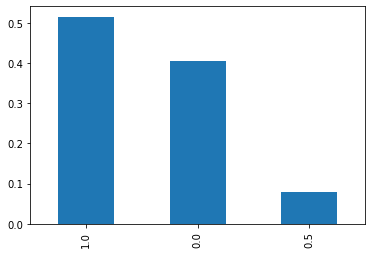

In [4]:
(data.scorer.value_counts() / len(data)).plot(kind='bar')

In [5]:
id = data.id.unique()[8]
data.loc[data.id==id, "scorer"].value_counts()


0.0    3170
1.0    2234
0.5     249
Name: scorer, dtype: int64

In [6]:
onegame = data.loc[data.id==id]
onepoint = onegame.loc[data.pt==3]

Here's a fun way to examine this data. We can extract one point and animate the ball as it moves around the field.

In [7]:
x = onepoint.y.values
y = onepoint.z.values
color=['C0','C1'][int(onepoint.scorer.mode()[0])]
interval=7
tail = 20
fig,ax = plt.subplots()
WIDTH = 100
HEIGHT = 600 / 5

# ===============
%matplotlib widget

ln, = plt.plot([], [], 'o', c=color, alpha=0.8)

def init():
    ax.set_xlim(-WIDTH,WIDTH)
    ax.set_ylim(-HEIGHT, HEIGHT)
    return ln,

def update(frame):
    #print(frame)
    ln.set_data(x[max(0,frame-tail):frame], y[max(0,frame-tail):frame])
    return ln,

ani = FuncAnimation(fig, update, frames=np.arange(len(x)),
                    init_func=init, blit=True, interval=interval)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [24]:
%matplotlib inline
gb = data.groupby(['id', 'pt'])
x_fn = lambda s: s.iloc[-1]
#scorers = gb['scorer'].agg({'scorer':pd.Series.mode, 'ending_x': x_fn, 'ending_y': y_fn
final_seconds = gb.agg({'scorer':pd.Series.mode, 'x':x_fn, 'y':x_fn})

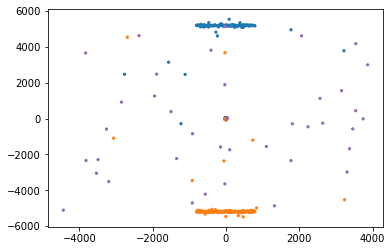

In [25]:
plt.figure()
color_fn = lambda scorer: f"C{int(scorer)}" if scorer % 1 == 0 else "C4"
plt.scatter(final_seconds.x, final_seconds.y, s=5, c=final_seconds.scorer.map(color_fn))
plt.show()

In [26]:
#plt.figure()
is_weird = (final_seconds.y.abs() < 5000)
is_not_weird = (final_seconds.y.abs() > 5000)
print(f"{is_weird.mean():.2%}")

30.47%


So we can reasonably affirm these relationships:

| Team 0 | Team 1 |
|--|--|
| `+y` | `-y` |

Jeez, turns out 30% of the data is just kinda weird. What's going on there?

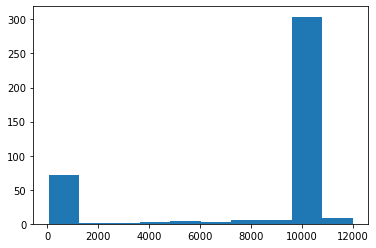

In [27]:
rangeof = lambda s: s.abs().max()*2
is_long = gb.t.agg(max)
ranges = gb.y.agg(rangeof)
plt.hist(ranges)
plt.show()

Max of small-scale: 109.0


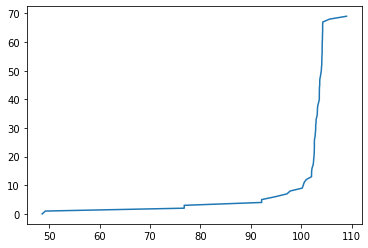

In [28]:
small_ranges = ranges.loc[ranges<110]
plt.plot(sorted(small_ranges), np.arange(len(small_ranges)))
print("Max of small-scale:", max(small_ranges))

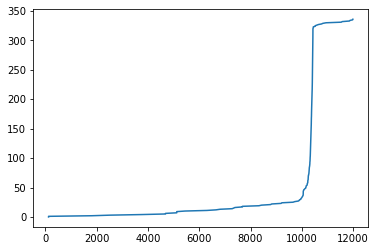

Max of large-scale: 11989.4


In [13]:
large_ranges = ranges.loc[ranges>110]
plt.plot(sorted(large_ranges), np.arange(len(large_ranges)))
plt.show()
print("Max of large-scale:", max(large_ranges))

I wonder if the scale of the replay files changed at some date.

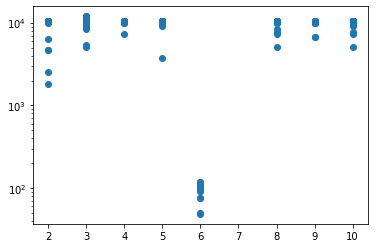

In [14]:
plt.scatter(gb.month.agg('mean'), ranges)
plt.yscale('log')

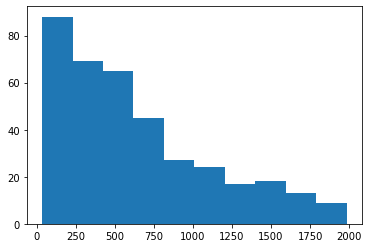

In [15]:
lengths = gb.agg(len)['f']
plt.hist(lengths.loc[lengths<2000])
plt.show()


I guess something weird happened in June. We can drop all those entries though.

In [16]:
dataf = data.loc[data.month != 6]
dataf

,f,ix,t,x,y,z,dx,dy,dz,scorer,pt,month,id
0,0,0,12.733936,0.00,0.00,92.87,0.00,0.00,0.00,1.0,0,2,02BC803B4481747BDB6B6FA3452F2796
1,127,0,18.879103,22.88,-38.32,94.99,1512.35,-2715.01,220.28,1.0,0,2,02BC803B4481747BDB6B6FA3452F2796
2,128,0,18.927488,98.43,-173.95,105.04,1510.01,-2710.87,187.44,1.0,0,2,02BC803B4481747BDB6B6FA3452F2796
3,129,0,18.975874,148.73,-264.25,110.84,1508.45,-2708.11,165.57,1.0,0,2,02BC803B4481747BDB6B6FA3452F2796
4,130,0,19.024260,249.17,-444.58,120.24,1505.33,-2702.59,121.91,1.0,0,2,02BC803B4481747BDB6B6FA3452F2796
...,...,...,...,...,...,...,...,...,...,...,...,...,...
334673,12057,58,502.687100,-3841.10,-2414.95,109.46,173.93,594.30,-87.03,0.5,10,2,6888472A40C49AEA06D91BA24A4FEA34
334674,12058,58,502.720370,-3838.20,-2405.05,107.87,173.83,594.00,-97.81,0.5,10,2,6888472A40C49AEA06D91BA24A4FEA34
334675,12059,58,502.753630,-3829.50,-2375.37,102.05,173.53,593.10,-130.12,0.5,10,2,6888472A40C49AEA06D91BA24A4FEA34
334676,12060,58,502.786900,-3823.71,-2355.61,97.27,173.33,592.50,-151.64,0.5,10,2,6888472A40C49AEA06D91BA24A4FEA34


We assign the replays to test and train by IDs, so that we don't have data from the same replay in both the training and testing sets.

In [17]:
train_ids, test_ids = train_test_split(dataf.id.unique())

features = ['t', 'x', 'y', 'z']#, 'dx', 'dy', 'dz']

X_train = dataf.loc[data.id.isin(train_ids), features]
y_train = dataf.loc[data.id.isin(train_ids), 'scorer']
X_test = dataf.loc[data.id.isin(test_ids), features]
y_test = dataf.loc[data.id.isin(test_ids), 'scorer']
#X_train, X_test, y_train, y_test = train_test_split(X, gb['scorer'])

<AxesSubplot:>

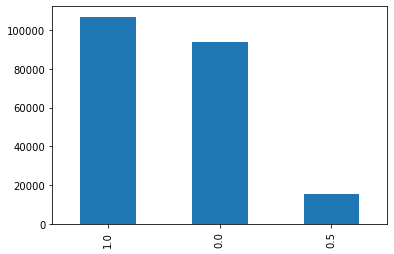

In [18]:
# Check for bias in training data
plt.figure()
y_train.value_counts().plot(kind='bar')

First we'll see how effective a simple logistic regression can be.

In [19]:
reclass = {0:0,1:1,0.5:3,3:3}
y_train = y_train.map(reclass)
y_test = y_test.map(reclass)
model = LogisticRegression(multi_class='multinomial')
model.fit(X_train, y_train)

/home/sam/miniconda3/envs/datasci/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [20]:
y_pred = model.predict(X_test)

In [21]:
(y_pred == y_test).mean()

0.4588700679582108

In [22]:
y_test.value_counts() / len(y_test)

1    0.576466
0    0.330130
3    0.093405
Name: scorer, dtype: float64

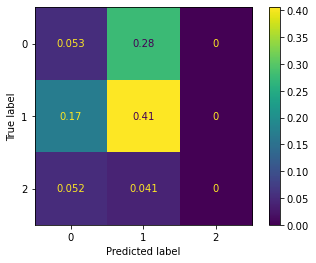

In [23]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)/len(y_test)).plot()